In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import math
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import joblib

In [122]:
df_original= pd.read_excel('C:/Users/henriquelucareli-ieg/Desktop/Recoope/Tudo/Analise Exploratoria/base_empresas_reciclagem_IA.xlsx')

display(df_original.head(5))

,Razão Social,Estado,Município,Ano,Tipo de Resíduo,Método de Reciclagem,Quantidade,Unidade de Medida,Empresa Destinadora do Resíduo,Situação Cadastral
0,IDEAL COMERCIO DE TAMBORES LTDA,SAO PAULO,GUARULHOS,2004,"Resíduo inflamável (resinas, etc)",Queima em formos industriais,-0.635066,kilogramas,40.263.170/0008-50 - SOLVÍ ESSENCIS AMBIENTAL ...,Ativa
1,COMÉRCIO DE SUCATAS MALLON LTDA - ME,SANTA CATARINA,SAO BENTO DO SUL,2009,Resíduo de papel e papelão,Outros,-0.597463,kilogramas,97.469.506/0001-86 - COMERCIO E TRANSPORTES FE...,Ativa
2,COMÉRCIO DE SUCATAS MALLON LTDA - ME,SANTA CATARINA,SAO BENTO DO SUL,2009,Sucata de metais ferrosos,Outros,-0.575669,kilogramas,07.358.761/0033-46 - GERDAU AÇOS LONGOS S.A.,Ativa
3,GSM - CENTRO DE RECICLAGEM E GESTAO AMBIENTAL ...,PARANA,SAO JOSE DOS PINHAIS,2000,"Sucata de metais não ferrosos (latão, etc.)",Outros,-0.609894,kilogramas,01.300.758/0001-08 - BOING COMÉRCIO DE METAIS ...,Ativa
4,GSM - CENTRO DE RECICLAGEM E GESTAO AMBIENTAL ...,PARANA,SAO JOSE DOS PINHAIS,2000,"Sucata de metais não ferrosos (latão, etc.)",Outros,-0.560688,kilogramas,78.404.860/0001-88 - BRASILSAT HARALD SA,Ativa


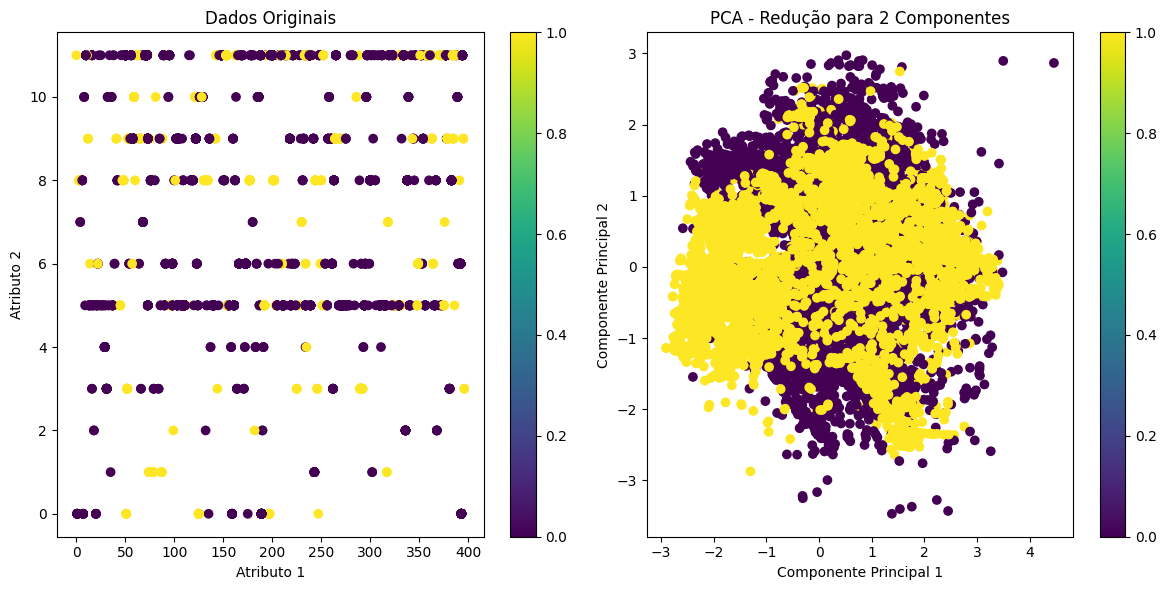

Taxa de acertos com dados originais: 0.8613821138211382
Taxa de acertos com PCA: 0.8394308943089431
              precision    recall  f1-score   support

       Ativa       0.84      0.97      0.90      1827
   Encerrado       0.84      0.46      0.60       633

    accuracy                           0.84      2460
   macro avg       0.84      0.72      0.75      2460
weighted avg       0.84      0.84      0.82      2460



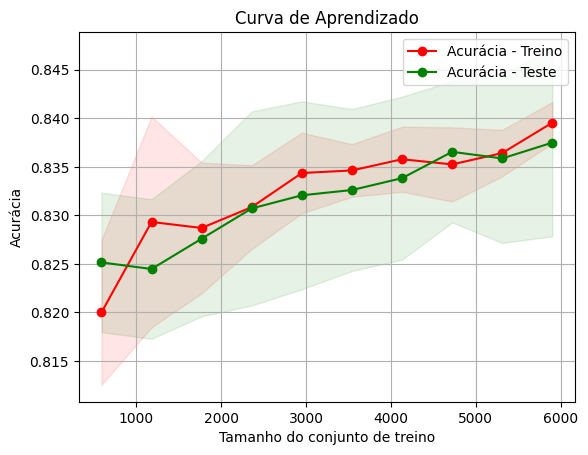

In [123]:
# Pré-processamento dos dados
df_x = df_original.iloc[:, :-1]
df_y = df_original.iloc[:, -1]

# Codificação de rótulos
label_encoder = LabelEncoder()
resposta_pre = label_encoder.fit_transform(df_y)

# Pré-processamento dos atributos
preprocessador = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(), make_column_selector(dtype_include='object')),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False 
)

atributo_pre = pd.DataFrame(preprocessador.fit_transform(df_x), columns=preprocessador.get_feature_names_out())

# Divisão em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(atributo_pre, resposta_pre, test_size=0.25, random_state=0)

# Aplicação do SMOTE
smote = SMOTE()
atributos_balanceado, resposta_balanceado = smote.fit_resample(X_train, y_train)

# Escalonamento dos atributos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(atributos_balanceado)

# PCA
pca = PCA(n_components=2)  # Reduzir para 2 componentes principais
X_pca = pca.fit_transform(X_scaled)

# Visualização dos dados originais e dos dados após PCA
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Atributo 1')
plt.ylabel('Atributo 2')
plt.title('Dados Originais')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=resposta_balanceado, cmap='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Redução para 2 Componentes')
plt.colorbar()

plt.tight_layout()
plt.show()

# Função para treinar e avaliar o modelo KNN
def knn_model(X_train, y_train, X_test):
    k = int(np.sqrt(len(y_train)))
    classificador_knn = KNeighborsClassifier(n_neighbors=k)
    classificador_knn.fit(X_train, y_train)
    y_pred = classificador_knn.predict(X_test)
    taxa_de_acerto = accuracy_score(y_test, y_pred)
    matriz_de_confusao = confusion_matrix(y_test, y_pred)
    return y_pred, taxa_de_acerto, matriz_de_confusao, classificador_knn

# Treinando e avaliando o modelo com dados originais
y_pred_knn, taxa_de_acerto, matriz_de_confusao, classificador_knn = knn_model(X_train, y_train, X_test)

# Aplicando PCA
X_train_pca = pca.transform(scaler.transform(X_train))
X_test_pca = pca.transform(scaler.transform(X_test))

# Treinando e avaliando o modelo com dados transformados por PCA
y_pred_knn_pca, taxa_de_acerto_pca, matriz_de_confusao_pca, classificador_knn_pca = knn_model(X_train_pca, y_train, X_test_pca)

# Resultados
print('Taxa de acertos com dados originais:', taxa_de_acerto)
print('Taxa de acertos com PCA:', taxa_de_acerto_pca)

# Relatório de classificação
rotulos_distintos = list(df_original["Situação Cadastral"].unique())
relatorio = classification_report(y_test, y_pred_knn_pca, target_names=rotulos_distintos)
print(relatorio)

# Curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(classificador_knn_pca, X_train_pca, y_train, cv=5, 
                                                         scoring='accuracy', 
                                                         train_sizes=np.linspace(0.1, 1.0, 10))

# Cálculo das médias e desvios padrões
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotando as curvas de aprendizado
plt.figure()
plt.title("Curva de Aprendizado")
plt.xlabel("Tamanho do conjunto de treino")
plt.ylabel("Acurácia")

# Área sombreada para desvios padrões
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Curvas de treino e teste
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Acurácia - Treino")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Acurácia - Teste")

plt.legend(loc="best")
plt.grid()
plt.show()


In [124]:
import math
def knn(X_train,y_train,df):
    k=int(math.sqrt(len(df)))

    classificador_knn= KNeighborsClassifier(n_neighbors=k)

    classificador_knn.fit(X_train,y_train)

    previsoes=classificador_knn.predict(X_test)

    y_pred_knn = classificador_knn.predict(X_test)

    taxa_de_acerto = accuracy_score(y_test, y_pred_knn)

    matriz_de_confusao = confusion_matrix(y_test, y_pred_knn)

    return previsoes,taxa_de_acerto,matriz_de_confusao,classificador_knn,y_pred_knn,k

Acurácia:  0.8638211382113821


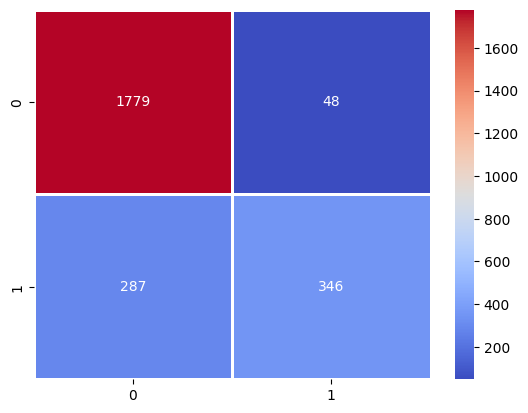

In [125]:
previsoes,taxa_de_acerto,matriz_de_confusao,classificador_knn,y_pred_knn,k=knn(X_train,y_train,df_original)

print('Acurácia: ',taxa_de_acerto)

sns.heatmap(matriz_de_confusao, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()

In [126]:
relatorio = classification_report(y_test, y_pred_knn, target_names= rotulos_distintos)
print("Taxa de acerto: ",taxa_de_acerto)
print(relatorio)

Taxa de acerto:  0.8638211382113821
              precision    recall  f1-score   support

       Ativa       0.86      0.97      0.91      1827
   Encerrado       0.88      0.55      0.67       633

    accuracy                           0.86      2460
   macro avg       0.87      0.76      0.79      2460
weighted avg       0.87      0.86      0.85      2460



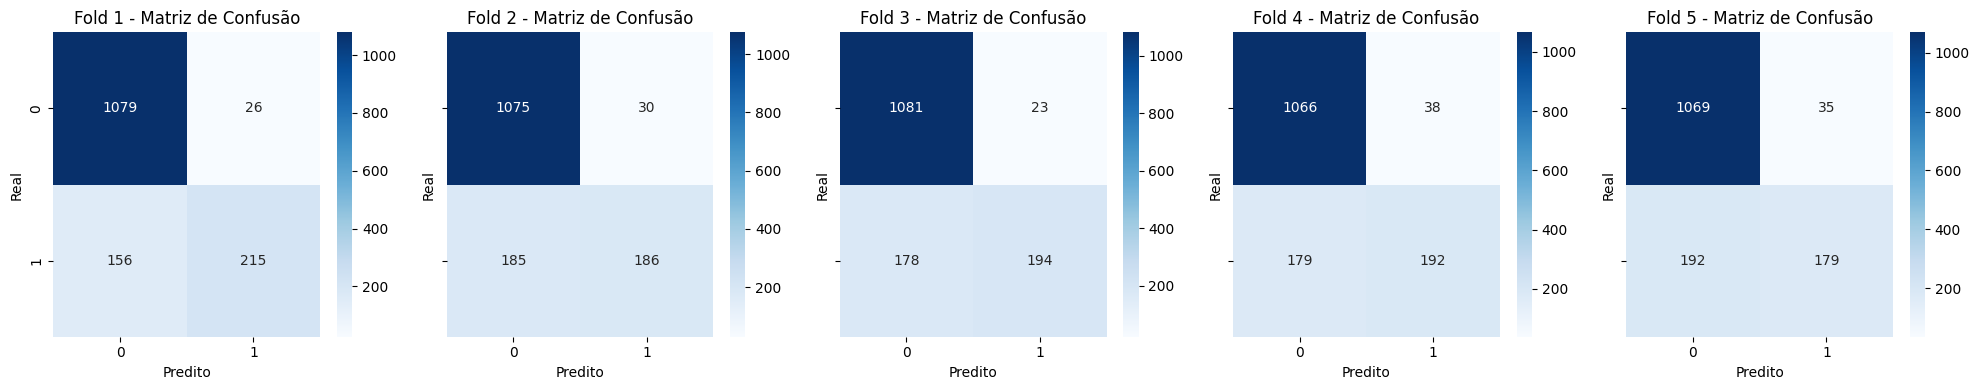

Acurácia do Fold 1: 0.87669
Acurácia do Fold 2: 0.85434
Acurácia do Fold 3: 0.86382
Acurácia do Fold 4: 0.85288
Acurácia do Fold 5: 0.84610


In [128]:
X, y = X_train, y_train

skf = StratifiedKFold(n_splits=5)

y_pred = cross_val_predict(classificador_knn, X, y, cv=5)

# Calcular matrizes de confusão
conf_matrices = [confusion_matrix(y[test_index], y_pred[test_index])
                 for train_index, test_index in skf.split(X, y)]

# Plotar as matrizes de confusão para cada fold
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey='row')
for i, conf_matrix in enumerate(conf_matrices):
    sns.heatmap(conf_matrix, annot=True, fmt="d", ax=axes[i], cmap="Blues")
    axes[i].set_title(f'Fold {i+1} - Matriz de Confusão')
    axes[i].set_xlabel('Predito')
    axes[i].set_ylabel('Real')
    

plt.tight_layout()
plt.show()
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Acurácia para o fold atual
    fold_accuracy = accuracy_score(y[test_index], y_pred[test_index])
    print(f'Acurácia do Fold {i+1}: {fold_accuracy:.5f}')

In [129]:
relatorio = classification_report(y_test, y_pred_knn, target_names= rotulos_distintos)
print("Taxa de acerto: ",taxa_de_acerto)
print(relatorio)

Taxa de acerto:  0.8638211382113821
              precision    recall  f1-score   support

       Ativa       0.86      0.97      0.91      1827
   Encerrado       0.88      0.55      0.67       633

    accuracy                           0.86      2460
   macro avg       0.87      0.76      0.79      2460
weighted avg       0.87      0.86      0.85      2460



In [130]:
teste = pd.DataFrame([{
    "Razão Social": 'IDEAL COMERCIO DE TAMBORES LTDA',
    "Estado": 'SAO PAULO',
    "Município": 'GUARULHOS',
    "Ano": 2004,
    "Tipo de Resíduo": 'Resíduo inflamável (resinas, etc)',
    "Método de Reciclagem": 'Queima em formos industriais',
    "Quantidade": -0.635066,
    "Unidade de Medida": 'kilogramas',
    "Empresa Destinadora do Resíduo": '40.263.170/0008-50 - SOLVÍ ESSENCIS AMBIENTAL S.A.'
}])
display(teste)


,Razão Social,Estado,Município,Ano,Tipo de Resíduo,Método de Reciclagem,Quantidade,Unidade de Medida,Empresa Destinadora do Resíduo
0,IDEAL COMERCIO DE TAMBORES LTDA,SAO PAULO,GUARULHOS,2004,"Resíduo inflamável (resinas, etc)",Queima em formos industriais,-0.635066,kilogramas,40.263.170/0008-50 - SOLVÍ ESSENCIS AMBIENTAL ...


In [131]:
pipeline = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('model', classificador_knn)
])

# Salvar o pipeline em um arquivo
with open('pipeline.pkl', 'wb') as arquivo:
    joblib.dump(pipeline, arquivo)

# Carregando o pipeline
with open('pipeline.pkl', 'rb') as arquivo:
    pipeline_carregado = joblib.load(arquivo)

# Fazer previsões diretamente com os dados de teste
predicoes = pipeline_carregado.predict(teste)

# Exibir as previsões
print("Previsões:", predicoes)

Previsões: [1]


c:\Users\henriquelucareli-ieg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

